In [72]:

import os
import random
import numpy as np
import yfinance as yf
import torch.nn as nn
import pandas as pd
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.regression.linear_model import OLS
# import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline



In [73]:
class TF(nn.Module):
    def __init__(self, ticker, start_date, end_date, riskfree_rate=0.04):
        super(TF, self).__init__()
        self.ticker_list = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.riskfree_rate = riskfree_rate
        self.stock = self.get_stock_data()

    def get_stock_data(self):
        print("===== DOWNLOADING STOCK DATA =====")
        df = yf.download(self.ticker_list, start=self.start_date, end=self.end_date)['Adj Close']
        print("===== DOWNLOAD COMPLETE =====")

        return pd.DataFrame(df)

    def forward(self, sma_len1, sma_len2):
        # add sma columns
        stock_df = self.stock.copy()
        stock_df["sma_"+str(sma_len1)] = stock_df['Adj Close'].rolling(sma_len1).mean()
        stock_df["sma_"+str(sma_len2)] = stock_df['Adj Close'].rolling(sma_len2).mean()
        
        self.df_sma = stock_df
        print(stock_df)
        
        
        # drop na
        stock_df.dropna(inplace=True)
        # log returns of the Buy and Hold strategy
        stock_df['log_return_buy_n_hold'] = np.log(stock_df['Adj Close'] / stock_df['Adj Close'].shift(1))
        # identify buy and sell signal
        stock_df['signal'] = np.where(stock_df["sma"+str(sma_len1)] > stock_df["sma"+str(sma_len2)], 1, 0)
        stock_df['signal'] = np.where(stock_df["sma"+str(sma_len1)] < stock_df["sma"+str(sma_len2)], -1, stock_df['signal'])
        stock_df.dropna(inplace=True)
        # calculate instantaneous log return for trend following straetegy
        stock_df['log_return_trend_follow'] = stock_df['signal'] * stock_df['log_return_buy_n_hold']
        # calculate annualized return of trend following
        annualized_return_trend_follow = np.exp(stock_df['log_return_trend_follow']).prod()**(252/stock_df.shape[0])-1
        # calculate annualized volatility of trend following
        annualized_vol_trend_follow = (np.exp(stock_df['log_return_trend_follow'])-1).std()*(252**0.5)
        # calculate Sharpe ratio of trend following
        sharpe_ratio_trend_follow = (annualized_return_trend_follow - self.riskfree_rate) / annualized_vol_trend_follow
        # print(f"Sharpe Ratio of Trend Following Strat SMA" + sma_len1 + "&" + sma_len2 + sharpe_ratio_trend_follow)
        return sharpe_ratio_trend_follow
    
    def plot_sma_x(self):
        # colors for the line plot
        colors = ['blue', 'red']

        # line plot for original price and SMA
        self.df_sma.plot(color=colors, linewidth=3, figsize=(12,6))

        # modify ticks size
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(labels = self.df_sma.columns, fontsize=13)

        # title and labels
        plt.title('Daily adjusted closing price and its SMA', fontsize=20)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Price', fontsize=16)
        plt.show()
    

        


In [74]:
tf = TF(ticker="GOOG", start_date="2022-01-01", end_date="2023-01-01")

===== DOWNLOADING STOCK DATA =====
[*********************100%***********************]  1 of 1 completed
===== DOWNLOAD COMPLETE =====


In [75]:
tf.stock.head()

,Adj Close
Date,
2022-01-03,145.074493
2022-01-04,144.416504
2022-01-05,137.653503
2022-01-06,137.550995
2022-01-07,137.004501


In [76]:
tf(sma_len1=5, sma_len2=10)

             Adj Close        sma5      sma10
Date                                         
2022-01-03  145.074493         NaN        NaN
2022-01-04  144.416504         NaN        NaN
2022-01-05  137.653503         NaN        NaN
2022-01-06  137.550995         NaN        NaN
2022-01-07  137.004501  140.339999        NaN
...                ...         ...        ...
2022-12-23   89.809998   89.420000  91.387999
2022-12-27   87.930000   89.175999  90.824999
2022-12-28   86.459999   88.542000  89.885999
2022-12-29   88.949997   88.281999  89.249999
2022-12-30   88.730003   88.375999  89.003000

[251 rows x 3 columns]


-0.2132889784366124

In [77]:
tf(sma_len1=3, sma_len2=20)

             Adj Close        sma3      sma20
Date                                         
2022-01-03  145.074493         NaN        NaN
2022-01-04  144.416504         NaN        NaN
2022-01-05  137.653503  142.381500        NaN
2022-01-06  137.550995  139.873667        NaN
2022-01-07  137.004501  137.403000        NaN
...                ...         ...        ...
2022-12-23   89.809998   89.440000  94.423999
2022-12-27   87.930000   88.666667  94.007999
2022-12-28   86.459999   88.066666  93.558999
2022-12-29   88.949997   87.779999  92.933999
2022-12-30   88.730003   88.046666  92.306499

[251 rows x 3 columns]


0.6227101143352145

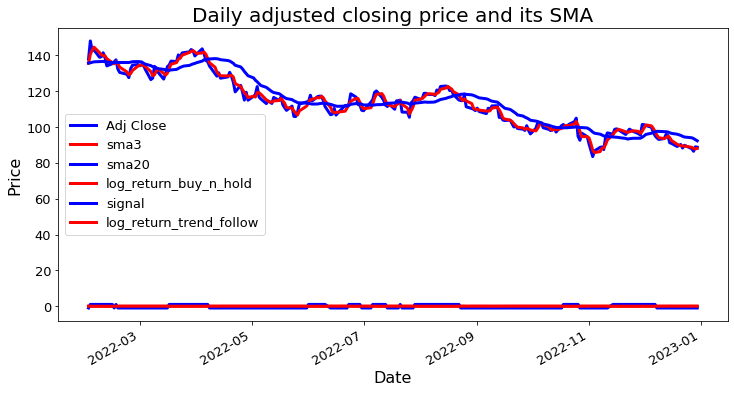

In [78]:
tf.plot_sma_x()